In [ ]:
!pip install gym==0.26.2
!pip install swig
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.7/721.7 kB 25.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for gym: filename=gym-0.26.2-py3-none-any.whl size=827728 sha256=eccbfddcbce49e73f841ff1155929c156ad90f79515c33e58d8bf6ed01ded3af
  Stored in directory: /root/.cache/pip/wheels/1c/77/9e/9af5470201a0b0543937933ee99ba884cd237d2faefe8f4d37
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling gym-0.25.2:
      Successfully uninstalled gym-0.25.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.1.2 requires gym<=0.25.2, but you have gym 0.26.2 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━

Необходимые библиотеки и выбор девайса:

In [ ]:
import math
import random
import numpy as np
from collections import namedtuple, deque
from itertools import count
from typing import Type
import gymnasium as gym
from gymnasium.wrappers import RecordVideo
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from dataclasses import dataclass
import copy

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


Параметры нейронной сети:

In [ ]:
@dataclass
class Params:
    batch_size: int = 64
    gamma: float = 0.99
    eps_start: float = 0.9
    eps_end: float = 0.05
    eps_decay: float = 0.95
    lr: float = 0.001
    n_steps: int = 5
    buff_size: int = 1000
    v_min: float = -100.0  # Minimum value of support
    v_max: float = 100.0   # Maximum value of support
    atoms: int = 100       # Number of atoms in distribution

### Буфер воспоминаний

#### Буффер для Dueling DQN

In [ ]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.tensor(state, dtype=torch.float32),
            torch.tensor(action, dtype=torch.long),
            torch.tensor(reward, dtype=torch.float32),
            torch.tensor(next_state, dtype=torch.float32),
            torch.tensor(done, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

#### Буффер для Multi-step learning DQN

In [ ]:
class MultiStepReplayBuffer:
    def __init__(self, capacity, n_steps, gamma):
        self.buffer = deque(maxlen=capacity)
        self.n_steps = n_steps
        self.gamma = gamma
        self.temp_buffer = deque(maxlen=n_steps)

    def push(self, *transition):
        self.temp_buffer.append(transition)

        if len(self.temp_buffer) >= self.n_steps or transition[4]:
            state, action, _, _, _ = self.temp_buffer[0]
            last_state, _, _, _, done = self.temp_buffer[-1]

            reward = 0
            for i in range(len(self.temp_buffer)):
                r = self.temp_buffer[i][2]
                reward += r * (self.gamma ** i)

            self.buffer.append((state, action, reward, last_state, done))

            if done:
                self.temp_buffer.clear()

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.tensor(state, dtype=torch.float32),
            torch.tensor(action, dtype=torch.long),
            torch.tensor(reward, dtype=torch.float32),
            torch.tensor(next_state, dtype=torch.float32),
            torch.tensor(done, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

#### Буффер для Distributional DQN

In [ ]:
class DistributionalReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, *transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = zip(*batch)
        return (
            torch.tensor(np.array(state), dtype=torch.float32),
            torch.tensor(action, dtype=torch.long),
            torch.tensor(reward, dtype=torch.float32),
            torch.tensor(np.array(next_state), dtype=torch.float32),
            torch.tensor(done, dtype=torch.float32),
        )

    def __len__(self):
        return len(self.buffer)

Методы:

- `__init__(self, capacity)` - задает буфер в виде очереди с максимальным размером capacity.
- `push(self, *args)` - добавление перехода в буффер.
- `sample(self, batch_size)` - сэмплирование (возврат из буфера `batch_size` рандомных переходов)
- `__len__(self)` - текущий размер буфера.

### Нейронная сеть для Q функции

#### Dueling DQN

In [ ]:
class DuelingDQN(nn.Module):
    def __init__(self, state_size, action_size, hiden_layers=256):
        super(DuelingDQN, self).__init__()
        self.feature = nn.Sequential(
            nn.Linear(state_size, hiden_layers),
            nn.ReLU(),
        )
        self.value_stream = nn.Sequential(
            nn.Linear(hiden_layers, hiden_layers),
            nn.ReLU(),
            nn.Linear(hiden_layers, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(hiden_layers, hiden_layers),
            nn.ReLU(),
            nn.Linear(hiden_layers, action_size)
        )

    def forward(self, x):
        x = self.feature(x)
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)
        return value + (advantage - advantage.mean(dim=-1, keepdim=True))

#### DQN

In [ ]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions, hiden_layers=256):
        super(DQN, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(n_observations, hiden_layers),
            nn.ReLU(),
            nn.Linear(hiden_layers, hiden_layers),
            nn.ReLU(),
            nn.Linear(hiden_layers, n_actions)
        )

    def forward(self, x):
        return self.net(x)

#### Distributional RL DQN

In [ ]:
class C51DQN(nn.Module):
    def __init__(self, n_observations, n_actions, atoms=51, hiden_layers=256):
        super(C51DQN, self).__init__()
        self.atoms = atoms
        self.n_actions = n_actions

        self.net = nn.Sequential(
            nn.Linear(n_observations, hiden_layers),
            nn.LayerNorm(hiden_layers),
            nn.ReLU(),
            nn.Linear(hiden_layers, hiden_layers),
            nn.ReLU(),
            nn.Linear(hiden_layers, n_actions * atoms)
        )

    def forward(self, x):
        batch_size = x.size(0)
        x = self.net(x)
        x = x.view(batch_size, self.n_actions, self.atoms)
        return torch.softmax(x, dim=2)


## Agent

### DuelingDQNAgent

In [ ]:
class DuelingDQNAgent:
    def __init__(self, model_type: Type[nn.Module], env: gym.Env, params: Params = None):
        initial_state, _ = env.reset()
        n_observations = len(initial_state)
        self.n_actions = env.action_space.n
        self.params = params if params else Params()

        self.q_net = model_type(n_observations, self.n_actions)
        self.target_net = model_type(n_observations, self.n_actions)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.params.lr)
        self.buffer = ReplayBuffer(self.params.buff_size)
        self.eps = self.params.eps_start
        self.q_net.to(device)
        self.target_net.to(device)

    def select_action(self, state):
        if random.random() < self.eps:
            return random.randint(0, self.n_actions - 1)

        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        with torch.no_grad():
            return self.q_net(state_tensor).argmax().item()

    def train_step(self):
        if len(self.buffer) < self.params.batch_size:
            return 0
        state, action, reward, next_state, done = self.buffer.sample(self.params.batch_size)
        state, action, reward, next_state, done = state.to(device), \
            action.to(device), reward.to(device), next_state.to(device), done.to(device)

        q_vals = self.q_net(state).gather(1, action.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            target = reward + self.params.gamma * self.target_net(next_state).max(1)[0] * (1 - done)
        loss = nn.MSELoss()(q_vals, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def update_epsilon(self):
        self.eps = max(self.eps * self.params.eps_decay, self.params.eps_end)

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())


### MultiStepDQNAgent

In [ ]:
class MultiStepDQNAgent:
    def __init__(self, model_type: Type[nn.Module], env: gym.Env, params: Params = None, buff_size = 1000):
        initial_state, _ = env.reset()
        n_observations = len(initial_state)
        self.n_actions = env.action_space.n
        self.params = params if params else Params()

        self.q_net = model_type(n_observations, self.n_actions)
        self.target_net = model_type(n_observations, self.n_actions)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.params.lr)
        self.buffer = MultiStepReplayBuffer(
            capacity=self.params.buff_size,
            n_steps=self.params.n_steps,
            gamma=self.params.gamma
        )
        self.eps = self.params.eps_start
        self.q_net.to(device)
        self.target_net.to(device)

    def select_action(self, state):
        if random.random() < self.eps:
            return random.randint(0, self.n_actions - 1)

        state_tensor = torch.tensor(state, dtype=torch.float32).to(device)
        with torch.no_grad():
            return self.q_net(state_tensor).argmax().item()

    def train_step(self):
        if len(self.buffer) < self.params.batch_size:
            return 0
        state, action, reward, next_state, done = self.buffer.sample(self.params.batch_size)
        state, action, reward, next_state, done = state.to(device), \
            action.to(device), reward.to(device), next_state.to(device), done.to(device)

        q_vals = self.q_net(state).gather(1, action.unsqueeze(1)).squeeze(1)
        with torch.no_grad():
            next_q = self.target_net(next_state).max(1)[0]
            target = reward + (self.params.gamma ** self.params.n_steps) * next_q * (1 - done)

        loss = nn.MSELoss()(q_vals, target)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def update_epsilon(self):
        self.eps = max(self.eps * self.params.eps_decay, self.params.eps_end)

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())


#### Distributional RL DQN

In [ ]:
class C51Agent:
    def __init__(self, model_type: Type[nn.Module], env: gym.Env, params: Params = None):
        initial_state, _ = env.reset()
        n_observations = len(initial_state)
        self.n_actions = env.action_space.n
        self.params = params if params else Params()

        # Создаем поддержку для распределения значений
        self.support = torch.linspace(self.params.v_min, self.params.v_max, self.params.atoms).to(device)
        self.delta_z = (self.params.v_max - self.params.v_min) / (self.params.atoms - 1)

        self.q_net = model_type(n_observations, self.n_actions, self.params.atoms).to(device)
        self.target_net = model_type(n_observations, self.n_actions, self.params.atoms).to(device)
        self.target_net.load_state_dict(self.q_net.state_dict())

        self.optimizer = optim.Adam(self.q_net.parameters(), lr=self.params.lr)
        self.buffer = DistributionalReplayBuffer(self.params.buff_size)
        self.eps = self.params.eps_start

    def select_action(self, state):
        if random.random() < self.eps:
            return random.randint(0, self.n_actions - 1)

        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            dist = self.q_net(state_tensor)
            q_values = (dist * self.support).sum(2)
            return q_values.argmax(1).item()

    def train_step(self):
        if len(self.buffer) < self.params.batch_size:
            return 0

        state, action, reward, next_state, done = self.buffer.sample(self.params.batch_size)
        state, action, reward, next_state, done = state.to(device), \
            action.to(device), reward.to(device), next_state.to(device), done.to(device)

        batch_size = state.size(0)

        # Compute current distribution
        current_dist = self.q_net(state)
        action = action.unsqueeze(1).unsqueeze(1).expand(-1, 1, self.params.atoms)
        current_dist = current_dist.gather(1, action).squeeze(1)
        current_dist = torch.clamp(current_dist, min=1e-5)

        with torch.no_grad():
            # 2. Вычисляем распределение для следующего состояния
            next_dist = self.target_net(next_state)
            next_action = (next_dist * self.support).sum(2).argmax(1)
            next_action = next_action.unsqueeze(1).unsqueeze(1).expand(-1, 1, self.params.atoms)
            next_dist = next_dist.gather(1, next_action).squeeze(1)

            # 3. Проектируем распределение на фиксированную поддержку
            target_z = reward.unsqueeze(1) + (1 - done.unsqueeze(1)) * self.params.gamma * self.support.unsqueeze(0)
            target_z = target_z.clamp(self.params.v_min, self.params.v_max)

            # Вычисляем индексы для проекции
            b = (target_z - self.params.v_min) / self.delta_z
            l = b.floor().long()
            u = b.ceil().long()

            # Clamp indices to be within the valid range [0, atoms - 1]
            l = torch.clamp(l, 0, self.params.atoms - 1)
            u = torch.clamp(u, 0, self.params.atoms - 1)

            # Распределяем вероятности
            proj_dist = torch.zeros_like(next_dist)
            offset = torch.linspace(0, (batch_size - 1) * self.params.atoms, batch_size).long()\
                .unsqueeze(1).expand(batch_size, self.params.atoms).to(device)

            # Исправление: используем оригинальный подход с index_add_
            proj_dist.view(-1).index_add_(
                0, (l + offset).view(-1),
                (next_dist * (u.float() - b)).view(-1)
            )
            proj_dist.view(-1).index_add_(
                0, (u + offset).view(-1),
                (next_dist * (b - l.float())).view(-1)
            )

        # Compute cross-entropy loss
        loss = -(proj_dist * torch.log(current_dist + 1e-7)).sum(1).mean()

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()

    def update_epsilon(self):
        self.eps = max(self.eps * self.params.eps_decay, self.params.eps_end)

    def update_target(self):
        self.target_net.load_state_dict(self.q_net.state_dict())

- `select_action(self, state)` - выбор действия на основе состояния state.
- `train_step(self)` - шаг обучения.
- `update_epsilon(self)` - обновление $\varepsilon$ для $\varepsilon$-жадной политики.
- `update_target(self)` - обновление таргетной сетки новыми значениями q-сетки.

### Обучение нейронной сети

Функция для вычисления награды, т.к. среда выдает всегда значение награды 0.

In [ ]:
def calculate_reward(state, done):
    position, velocity = state
    target_position = 0.5
    if done and position >= target_position:
        return 100.0

    reward = (position + 0.5) ** 2
    reward += 0.1 * velocity if velocity > 0 else 0
    return float(reward)

In [ ]:
def train(agent, env, n_epochs, steps):
    reward_history = []
    loss_history = []
    epoch_tqdm = tqdm(range(n_epochs))
    for epoch in epoch_tqdm:
        state, _ = env.reset()
        total_reward = 0
        total_loss = 0
        for _ in range(steps):
            action = agent.select_action(state)
            next_state, reward, done, truncated, _ = env.step(action)

            if env.spec.id == 'MountainCar-v0':
                reward = calculate_reward(state, done)

            agent.buffer.push(state, action, reward, next_state, float(done))
            loss = agent.train_step()
            state = next_state

            # print(f'Action {action}, reward {reward}')

            total_reward += reward
            total_loss += loss

            if done:
                break

        reward_history.append(total_reward)
        loss_history.append(total_loss)

        agent.update_epsilon()
        agent.update_target()
        epoch_tqdm.desc = f"Reward: {total_reward}, Loss: {total_loss}, Env_reward_threshold: {env.spec.reward_threshold}"

        #if np.mean(reward_history[-10:]) >= env.spec.reward_threshold:
        #    print(f"\nTask is completed for {epoch} episodes")
        #    break

    return reward_history, loss_history

### Функция построения графиков

In [ ]:
def plot_graphics(results, labels, main_title):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(21, 6))
    fig.tight_layout(pad=5.0)
    fig.suptitle(main_title, fontsize=14)

    ax1.set_title("Reward")
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Reward')
    ax1.grid(True)

    ax2.set_title("Loss")
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.grid(True)

    for (rewards, losses), label in zip(results, labels):
        ax1.plot(rewards, label=label)
        ax2.plot(losses, label=label)

    ax1.legend()
    ax2.legend()

    plt.show()

### Эксперимент различных архитектур нейронной сети

In [ ]:
def experiment_models(env):
    labels = ["Dueling networks", "Multi-step learning", "Distributional RL"]
    agents = [DuelingDQNAgent(DuelingDQN, env), MultiStepDQNAgent(DQN, env), C51Agent(C51DQN, env)]
    results = []

    for agent, label in zip(agents, labels):
        print(f"{label} model training...")

        all_rewards = []
        all_losses = []

        for run in range(7):
            print(f"Run {run + 1}/7")
            agent_copy = copy.deepcopy(agent)
            rewards, losses = train(agent_copy, env, 500, 200)
            all_rewards.append(rewards)
            all_losses.append(losses)

        avg_rewards = np.mean(all_rewards, axis=0)
        avg_losses = np.mean(all_losses, axis=0)

        results.append((avg_rewards, avg_losses))

    plot_graphics(results, labels, "Network")

## Эксперименты

Dueling networks model training...
Run 1/7


  0%|          | 0/500 [00:00<?, ?it/s]<ipython-input-21-158263ea6528>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(state, dtype=torch.float32),
Reward: 108.19118151743311, Loss: 197.26096940040588, Env_reward_threshold: 200: 100%|██████████| 500/500 [06:05<00:00,  1.37it/s]


Run 2/7


Reward: 103.76404529756452, Loss: 64.99935079365969, Env_reward_threshold: 200: 100%|██████████| 500/500 [06:11<00:00,  1.35it/s]


Run 3/7


Reward: 106.25962596565313, Loss: 38.26054348796606, Env_reward_threshold: 200: 100%|██████████| 500/500 [06:09<00:00,  1.35it/s]


Run 4/7


Reward: 81.70755041517131, Loss: 44.2396939471364, Env_reward_threshold: 200: 100%|██████████| 500/500 [06:09<00:00,  1.35it/s]


Run 5/7


Reward: 90.40514897299265, Loss: 23.94404799491167, Env_reward_threshold: 200: 100%|██████████| 500/500 [06:12<00:00,  1.34it/s]


Run 6/7


Reward: 110.65678477554441, Loss: 675.2036001086235, Env_reward_threshold: 200: 100%|██████████| 500/500 [06:02<00:00,  1.38it/s]


Run 7/7


Reward: 85.59896694633895, Loss: 26.25785406306386, Env_reward_threshold: 200: 100%|██████████| 500/500 [06:11<00:00,  1.34it/s]


Multi-step learning model training...
Run 1/7


Reward: 83.8204026876328, Loss: 40011.5957365036, Env_reward_threshold: 200: 100%|██████████| 500/500 [03:55<00:00,  2.12it/s]


Run 2/7


Reward: 18.799698217795182, Loss: 8494.986625671387, Env_reward_threshold: 200: 100%|██████████| 500/500 [04:03<00:00,  2.05it/s]


Run 3/7


Reward: 16.37070262877782, Loss: 64080.66187286377, Env_reward_threshold: 200: 100%|██████████| 500/500 [03:41<00:00,  2.26it/s]


Run 4/7


Reward: -41.80635682188151, Loss: 4532.9532289505005, Env_reward_threshold: 200: 100%|██████████| 500/500 [03:41<00:00,  2.26it/s]


Run 5/7


Reward: 115.6209924516108, Loss: 3367.296296596527, Env_reward_threshold: 200: 100%|██████████| 500/500 [04:00<00:00,  2.08it/s]


Run 6/7


Reward: 59.62424095293791, Loss: 8024.701766014099, Env_reward_threshold: 200: 100%|██████████| 500/500 [03:59<00:00,  2.09it/s]


Run 7/7


Reward: -3.1621747680470946, Loss: 10213.720631599426, Env_reward_threshold: 200: 100%|██████████| 500/500 [04:05<00:00,  2.03it/s]


Distributional RL model training...
Run 1/7


Reward: -35.12591931568, Loss: 553.6230528354645, Env_reward_threshold: 200: 100%|██████████| 500/500 [05:53<00:00,  1.41it/s]


Run 2/7


Reward: 85.55909763154617, Loss: 542.0051732063293, Env_reward_threshold: 200: 100%|██████████| 500/500 [05:51<00:00,  1.42it/s]


Run 3/7


Reward: 48.83473274345893, Loss: 510.44147634506226, Env_reward_threshold: 200: 100%|██████████| 500/500 [05:43<00:00,  1.45it/s]


Run 4/7


Reward: 107.06954675411019, Loss: 533.6789932250977, Env_reward_threshold: 200: 100%|██████████| 500/500 [05:53<00:00,  1.42it/s]


Run 5/7


Reward: -40.270342894633984, Loss: 406.4680116176605, Env_reward_threshold: 200: 100%|██████████| 500/500 [05:47<00:00,  1.44it/s]


Run 6/7


Reward: -13.522626435590738, Loss: 413.71012258529663, Env_reward_threshold: 200: 100%|██████████| 500/500 [05:52<00:00,  1.42it/s]


Run 7/7


Reward: -4.643976927386646, Loss: 444.5694260597229, Env_reward_threshold: 200: 100%|██████████| 500/500 [05:55<00:00,  1.41it/s]


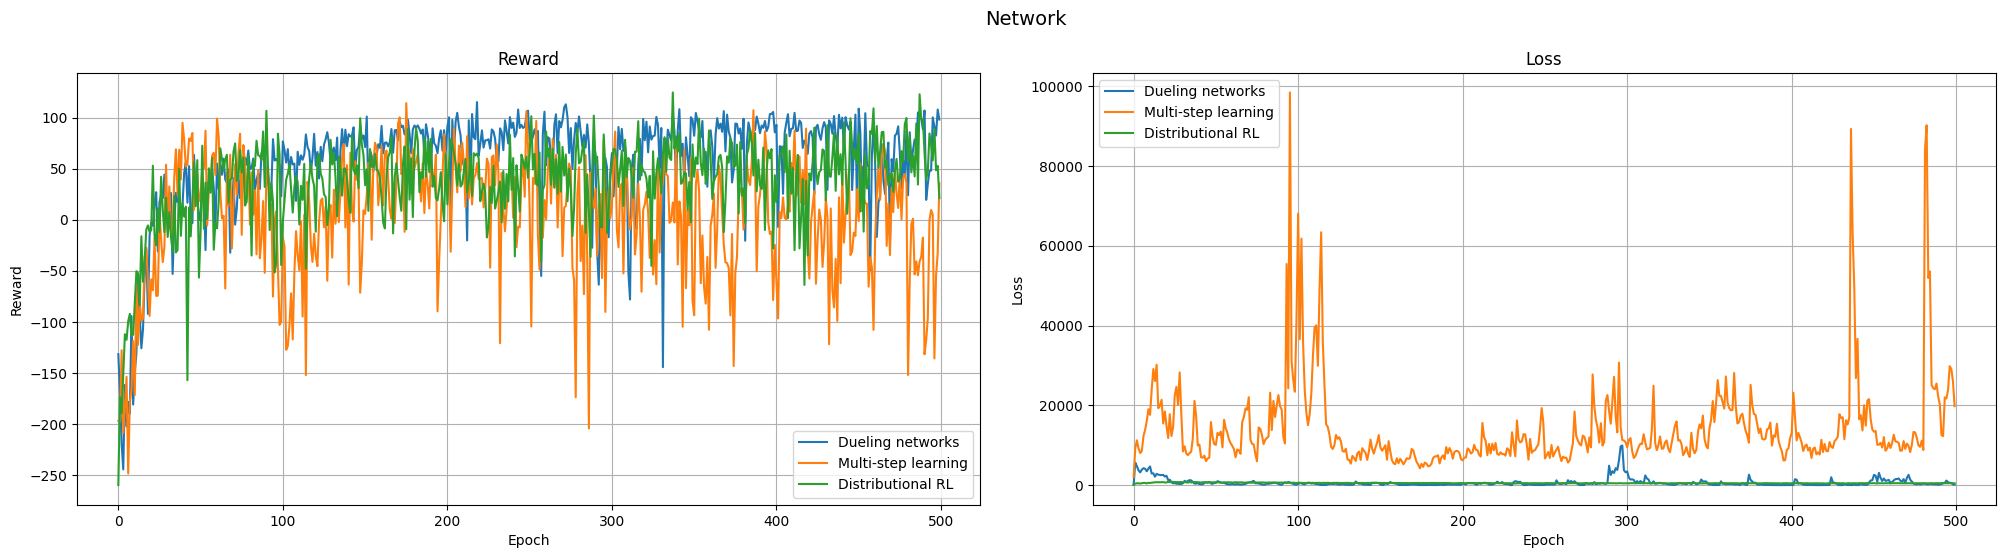

In [ ]:
env = gym.make("LunarLander-v3")
experiment_models(env)

Dueling networks model training...
Run 1/7


Reward: 106.66064374880716, Loss: 3.160396409686655, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [05:56<00:00,  1.40it/s]


Run 2/7


Reward: 102.0388155169785, Loss: 7.476497607305646, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [05:51<00:00,  1.42it/s]


Run 3/7


Reward: 53.9041358786053, Loss: 11.761976059526205, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [05:50<00:00,  1.43it/s]


Run 4/7


Reward: 45.83130196484149, Loss: 12.028211813420057, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [05:57<00:00,  1.40it/s]


Run 5/7


Reward: 63.14110376373368, Loss: 12.757220795378089, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [06:02<00:00,  1.38it/s]


Run 6/7


Reward: 114.64873791259379, Loss: 8.567526304163039, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [05:52<00:00,  1.42it/s]


Run 7/7


Reward: 56.21577721296774, Loss: 10.441819427534938, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [05:52<00:00,  1.42it/s]


Multi-step learning model training...
Run 1/7


Reward: 58.44240488573769, Loss: 944.8259543776512, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [04:20<00:00,  1.92it/s]


Run 2/7


Reward: 48.81064353765396, Loss: 1100.5166574120522, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [04:26<00:00,  1.88it/s]


Run 3/7


Reward: 50.30322083824967, Loss: 1702.5515022873878, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [04:22<00:00,  1.90it/s]


Run 4/7


Reward: 27.68737004618265, Loss: 379.1705437004566, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [04:26<00:00,  1.87it/s]


Run 5/7


Reward: 33.76336028187211, Loss: 756.240002155304, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [04:31<00:00,  1.84it/s]


Run 6/7


Reward: 26.296602430491475, Loss: 660.8485834002495, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [04:23<00:00,  1.90it/s]


Run 7/7


Reward: 47.04683992540663, Loss: 1258.8146691918373, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [04:27<00:00,  1.87it/s]


Distributional RL model training...
Run 1/7


Reward: 64.56690308081852, Loss: 367.41883516311646, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [06:00<00:00,  1.39it/s]


Run 2/7


Reward: 56.87863020695784, Loss: 371.3227872848511, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [05:59<00:00,  1.39it/s]


Run 3/7


Reward: 30.84994305696091, Loss: 343.9655785560608, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [05:52<00:00,  1.42it/s]


Run 4/7


Reward: 66.13619061833015, Loss: 381.4260218143463, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [05:55<00:00,  1.41it/s]


Run 5/7


Reward: 119.05542277808684, Loss: 408.0309331417084, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [05:57<00:00,  1.40it/s]


Run 6/7


Reward: 65.02915858815277, Loss: 415.5780551433563, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [06:08<00:00,  1.36it/s]


Run 7/7


Reward: 116.49185850447338, Loss: 387.58702516555786, Env_reward_threshold: -110.0: 100%|██████████| 500/500 [05:59<00:00,  1.39it/s]


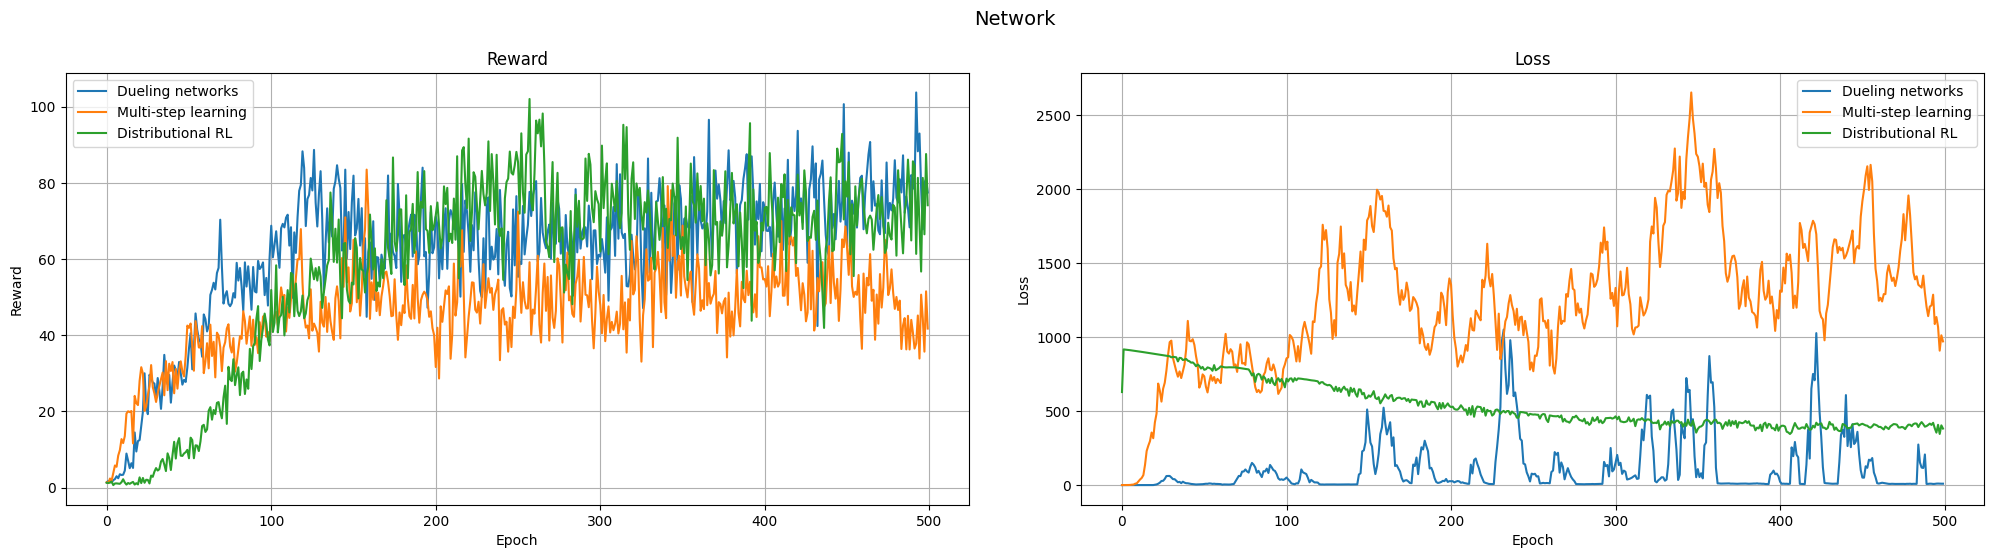

In [ ]:
env = gym.make("MountainCar-v0")
experiment_models(env)

## Визуализация результатов

Функция визуализации обученной модели (запись сохраняется в папку `videos`)

In [ ]:
def visualize_agent_performance(agent, env_name, model_name):
    env = gym.make(env_name, render_mode="rgb_array")
    env = RecordVideo(env,
                     video_folder="./videos",
                     name_prefix=model_name,
                     video_length=7000,
                     episode_trigger=lambda x: True)

    state, _ = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = agent.select_action(state)
        state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated
        total_reward += reward

    env.close()
    print("Видео сохранены в папку ./videos")

### Обучение агента

#### DuelingDQNAgent

In [ ]:
env = gym.make("LunarLander-v3")
agent1 = DuelingDQNAgent(DuelingDQN, env)
results1 = train(agent1, env, n_epochs=600, steps=300)

env = gym.make("MountainCar-v0")
agent2 = DuelingDQNAgent(DuelingDQN, env)
results2 = train(agent2, env, n_epochs=600, steps=300)

  0%|          | 0/600 [00:00<?, ?it/s]<ipython-input-4-158263ea6528>:12: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  torch.tensor(state, dtype=torch.float32),
Reward: 96.93383754875774, Loss: 53.057062946259975, Env_reward_threshold: 200: 100%|██████████| 600/600 [29:37<00:00,  2.96s/it]
Reward: 198.6070410598477, Loss: 4.696646089665592, Env_reward_threshold: -110.0:  20%|██        | 123/600 [04:26<17:12,  2.17s/it]


KeyboardInterrupt: 

#### Графики его обучения

In [ ]:
plot_graphics([results1], ['DuelingDQN'], "DuelingDQN-LunarLander-v3")
plot_graphics([results2], ['DuelingDQN'], "DuelingDQN-MountainCar-v0")

#### Визуализация

In [ ]:
visualize_agent_performance(agent1, 'LunarLander-v3', 'dueling-dqn-lander')
visualize_agent_performance(agent2, 'MountainCar-v0', 'dueling-dqn-car')

#### Multi-step learning

In [ ]:
env = gym.make("LunarLander-v3")
agent1 = MultiStepDQNAgent(DQN, env)
results1 = train(agent1, env, n_epochs=600, steps=300)

env = gym.make("MountainCar-v0")
agent2 = MultiStepDQNAgent(DQN, env)
results2 = train(agent2, env, n_epochs=600, steps=300)

Графики его обучения

In [ ]:
plot_graphics([results1], ['Multi-step learning'], "Multi-step learning-LunarLander-v3")
plot_graphics([results2], ['Multi-step learning'], "Multi-step learning-MountainCar-v0")

Визуализация

In [ ]:
visualize_agent_performance(agent2, 'LunarLander-v3', 'multi-step-dqn-lander')
visualize_agent_performance(agent2, 'MountainCar-v0', 'multi-step-dqn-car')

#### Distributional RL

In [ ]:
env = gym.make('LunarLander-v3')
agent1 = C51Agent(C51DQN, env)
results1 = train(agent1, env, n_epochs=600, steps=300)

env = gym.make('MountainCar-v0')
agent2 = C51Agent(C51DQN, env)
results2 = train(agent2, env, n_epochs=600, steps=300)

Графики его обучения

In [ ]:
plot_graphics([results1], ['Distributional RL'], "Distributional RL-LunarLander-v3")
plot_graphics([results2], ['Distributional RL'], "Distributional RL-MountainCar-v0")

Визуализация

In [ ]:
visualize_agent_performance(agent1, 'LunarLander-v3', 'drl-dqn-lander')
visualize_agent_performance(agent2, 'MountainCar-v0', 'drl-dqn-car')